# クラス分類器の不確実性推定の方法

scikit-learn の `RandomForestClassifier` の `predict_proba` メソッドとツリー構造との関係、および `GradientBoostingClassifier` の `predict_proba` メソッド、`decision_function` メソッドとツリー構造の関係を調査する。


## 0. データの準備

サンプルデータセットとして、scikit-learn にあるワインデータを使う。

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

wine_dataset = load_wine()

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 入力特徴量のサイズ
wine_dataset.data.shape

(178, 13)

In [3]:
# 特徴量名
wine_dataset.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [4]:
# ターゲット名
wine_dataset.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [5]:
# データセットを訓練用、テスト用に分割
X_train, X_test, y_train, y_test = train_test_split(wine_dataset.data, wine_dataset.target, test_size=0.25, random_state=42)

## 1. RandomForestClassifier

ワインデータの分類器を `RandomForestClassifier` で作成、訓練し、ツリー構造と `predict_proba` メソッドとの関係を調べる。なお、`RandomForestClassifier` に `decision_function` メソッドは実装されていない。

`RandomForestClassifier` で分類器を作成、訓練すると、`n_estimators` で指定した数の `DecisionTreeClassifier` が内部に作成される。

In [6]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators=3,
    max_depth=3,
    random_state=42)

# 特徴量名をモデル内に保存できるように DataFrame にして訓練する。
forest.fit(pd.DataFrame(X_train, columns=wine_dataset.feature_names), y_train)

RandomForestClassifier(max_depth=3, n_estimators=3, random_state=42)

In [7]:
# RandomForest が内部にもっているツリー群のひとつひとつのツリーのテンプレートとなるクラス。
forest.estimator_

DecisionTreeClassifier()

In [8]:
# RandomForest が内部にもっているツリー群。

forest.estimators_

[DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1935803228)]

In [9]:
# クラス変数の数は３つであり、それぞれ [0, 1, 2] である。

forest.n_classes_, forest.classes_

(3, array([0, 1, 2]))

In [10]:
# テストデータで正解率を見る。

forest.score(X_test, y_test)

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8666666666666667

`RandomForestClassifier` 内部に作成された ３つの `DecisionTreeClassifier` を可視化していく。

まず１つ目のツリー。

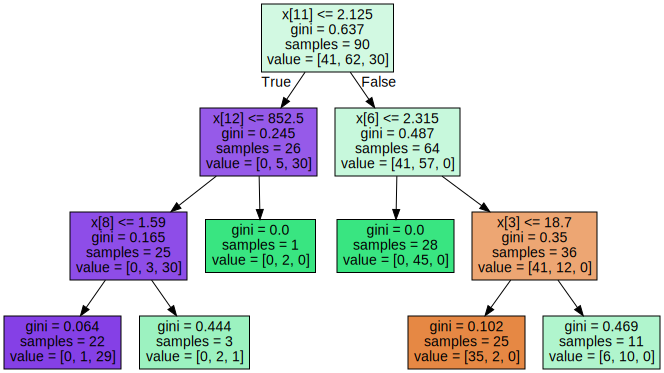

In [11]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    forest.estimators_[0],  # RandomForest 内部の最初のツリーを可視化
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

次に ２つめのツリー。

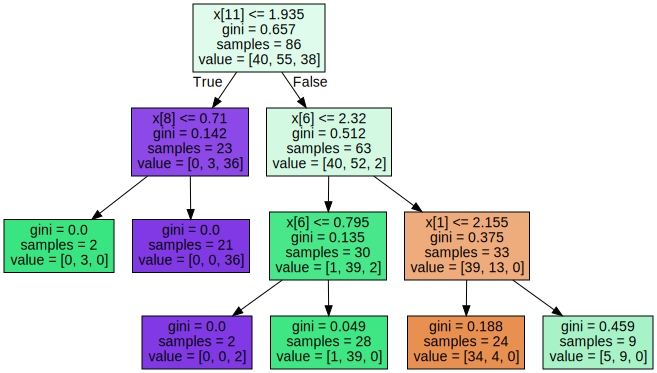

In [12]:
dot_data = export_graphviz(
    forest.estimators_[1],  # RandomForest 内部の最初のツリーを可視化
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

最後に ３つ目のツリー。

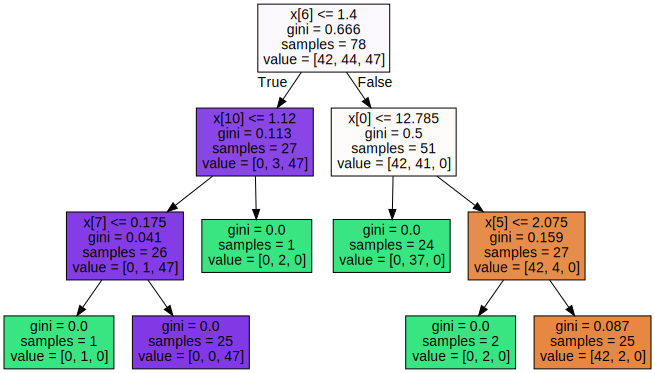

In [13]:
dot_data = export_graphviz(
    forest.estimators_[2],  # RandomForest 内部の最初のツリーを可視化
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

ここで、`X_test[13:14]` の特徴量と、`predict_proba` を使ってそれが所属するクラスの確率を求める。

In [14]:
X_test[13:14]

array([[ 12.77,   3.43,   1.98,  16.  ,  80.  ,   1.63,   1.25,   0.43,
          0.83,   3.4 ,   0.7 ,   2.12, 372.  ]])

In [15]:
forest.predict_proba(X_test[13:14])

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.00833333, 0.33611111, 0.65555556]])

`predict_proba` の結果は、Class 2 の確率が最大なので、この特徴量データは、Class 2 に所属すると判定されることになる。


`X_test[13:14]` の特徴量で各々のツリーをたどると結果がどのようになるかを見てみる。

ツリー０ では、`value = [0, 1, 29]` の Leaf に到達。この Leaf では、Class 0 は ０個、Class 1 は １個、Class 2 は ２９ 個存在する。したがって、各々の確率は、

- P(class 0) = 0/30 = 0
- P(class 1) = 1/30 = 0.0333333
- P(class 2) = 29/30 = 0.9666666

となる。

ツリー１ では、`value = [1, 39, 0]` の Leaf に到達。したがって、各々の確率は、

- P(class 0) = 1/40 = 0.025
- P(class 1) = 39/40 = 0.975
- P(class 2) = 0/40 = 0

ツリー２ では、`value = [0, 0, 47]` の Leaf に到達。したがって、各々の確率は

- P(class 0) = 0/47 = 0
- P(class 1) = 0/47 = 0
- P(class 2) = 47/47 = 1

である。これらの平均をとると、

In [16]:
print(f"P(class 0) = {0.025 / 3}")
print(f"P(class 1) = {(0.033333333333 + 0.975) / 3}")
print(f"P(class 2) = {(0.96666666 + 1) / 3}")

P(class 0) = 0.008333333333333333
P(class 1) = 0.336111111111
P(class 2) = 0.6555555533333334


となり、

In [17]:
forest.predict_proba(X_test[13:14])

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.00833333, 0.33611111, 0.65555556]])

と一致する。したがって、`RandomForestClassifier` における `predict_proba` の計算は、特徴量データで各決定木をたどっていった結果の Leaf における各クラスへの訓練データの所属数から計算する確率を全ツリーで平均した値となる。

## 2. GradientBoostingClassifier

`GradientBoostingClassifier` を作成、訓練すると、`n_estimators` パラメータで指定した数の評価器が内部に作成される。各評価器は、クラス変数ごとに独立した `DecisionTreeRegressor` で構成される。

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=2, max_depth=3, random_state=42)

# 特徴量名をモデル内に保存できるように DataFrame にして訓練する。
gbc.fit(pd.DataFrame(X_train, columns=wine_dataset.feature_names), y_train)

GradientBoostingClassifier(n_estimators=2, random_state=42)

In [19]:
# class 0, class 1, class 2 に対する DecisionTreeRegressor の三つ組が、n_estimators だけ生成されている。

gbc.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7FCD767B6940),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7FCD767B6940),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7FCD767B6940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7FCD767B6940),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7FCD767B6940),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7FCD767B6940)]],
      dtype=object)

In [20]:
gbc.n_classes_, gbc.classes_

(3, array([0, 1, 2]))

In [21]:
gbc.score(X_test, y_test)

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


0.8666666666666667

ソフトマックス関数を定義しておく。

In [22]:
def softmax(a):
    # 式(3.10)の計算
    c = np.max(a) # 最大値
    exp_a = np.exp(a - c) # 分子:オーバーフロー対策
    sum_exp_a = np.sum(exp_a) # 分母
    y = exp_a / sum_exp_a # 式(3.10)
    return y

特徴量データ `X_test[13:14]`

In [23]:
X_test[13:14]

array([[ 12.77,   3.43,   1.98,  16.  ,  80.  ,   1.63,   1.25,   0.43,
          0.83,   3.4 ,   0.7 ,   2.12, 372.  ]])

に対する `decision_function` メソッドによる不確実性は次のようになる。

In [24]:
gbc.decision_function(X_test[13:14])

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[-1.30025266, -0.60875393, -0.86696951]])

`predict_proba` メソッドによる不確実性は次のようになる。

In [25]:
gbc.predict_proba(X_test[13:14])

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[0.22031194, 0.43989813, 0.33978994]])

`decision_function` メソッドの結果を、先に定義しておいたソフトマックス関数にかけると次のようになる。

In [26]:
softmax(gbc.decision_function(X_test[13:14]))

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[0.22031194, 0.43989813, 0.33978994]])

このように、`GradientBoostingClassifier` では、`decision_function` の結果をソフトマックス関数で変換したものが、その特徴量データの各クラスへの所属確率、つまり `predict_proba` の結果となる。

したがって、

In [27]:
X_test[13:14]

array([[ 12.77,   3.43,   1.98,  16.  ,  80.  ,   1.63,   1.25,   0.43,
          0.83,   3.4 ,   0.7 ,   2.12, 372.  ]])

が各決定木をたどったときの Leaf の値と `decision_function` の結果の関係を調べればいい。

まず、Class ０ の２つの決定木を可視化する。

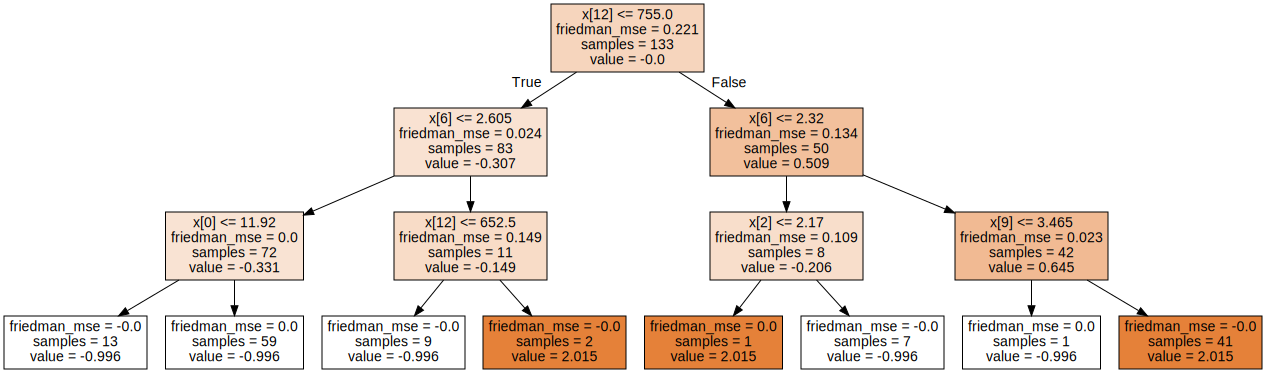

In [28]:
dot_data = export_graphviz(
    gbc.estimators_[0][0],
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

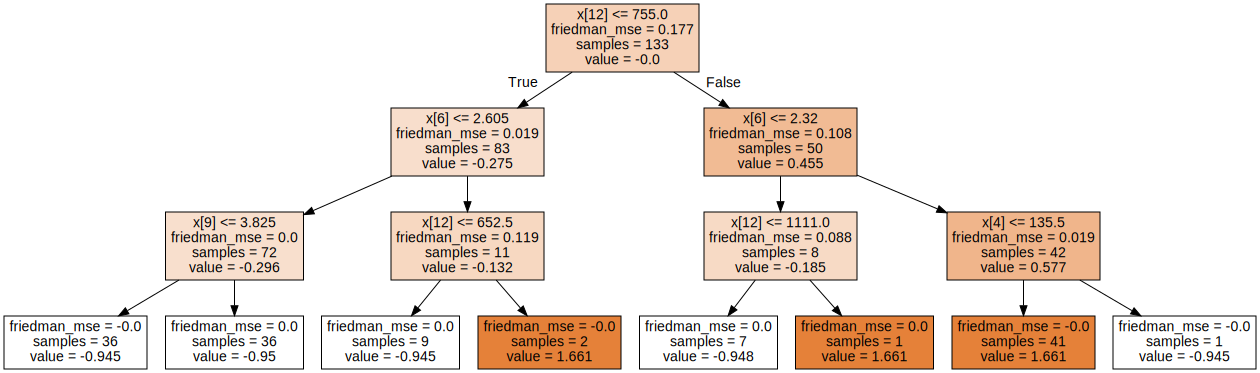

In [29]:
dot_data = export_graphviz(
    gbc.estimators_[1][0],
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

次に、Class 1 の２つの決定木を可視化する。

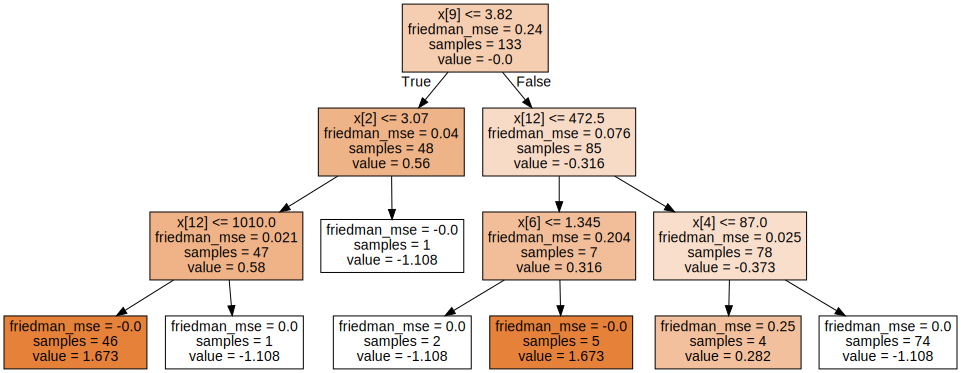

In [30]:
dot_data = export_graphviz(
    gbc.estimators_[0][1],
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

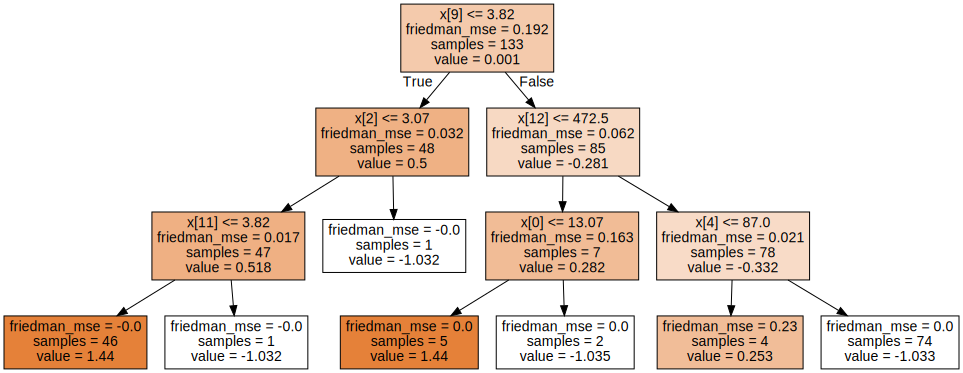

In [31]:
dot_data = export_graphviz(
    gbc.estimators_[1][1],
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

 最後に Class 2 の２つの決定木を可視化する。

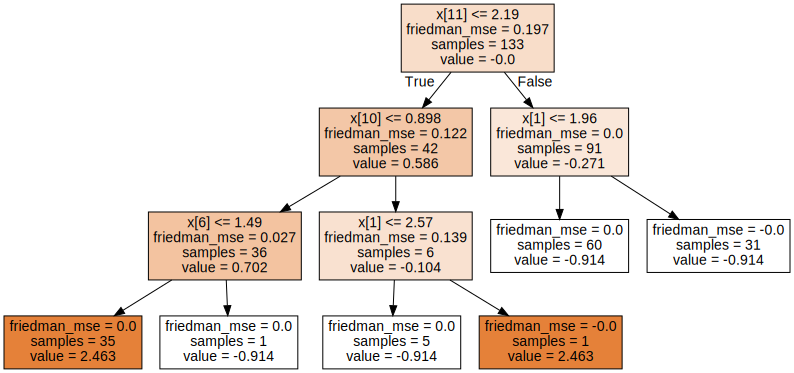

In [32]:
dot_data = export_graphviz(
    gbc.estimators_[0][2],
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

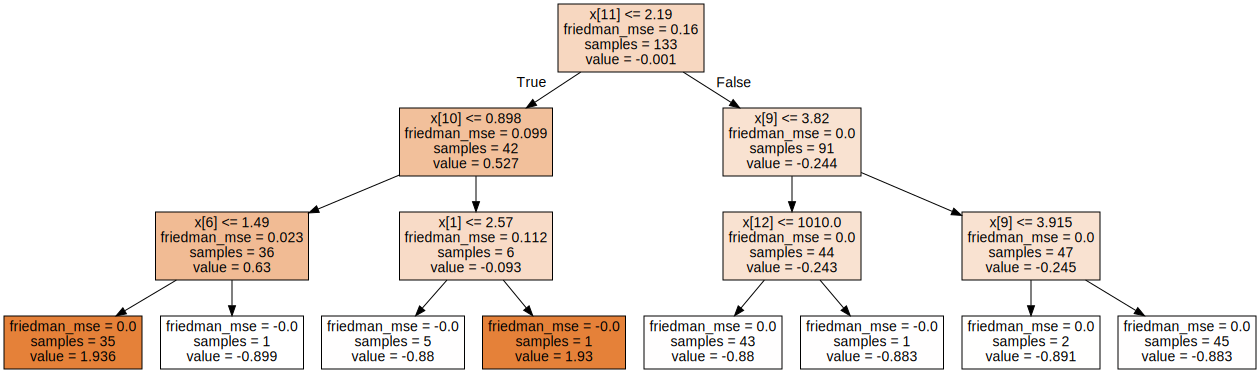

In [33]:
dot_data = export_graphviz(
    gbc.estimators_[1][2],
    out_file=None,
    filled=True)

graph = graphviz.Source(dot_data)
graph

`X_test[13:14]` が Class 0 の２つの決定木をたどったときの Leaf の値はそれぞれ

- `-0.996`
- `-0.945`

Class 1 の場合は

- `1.673`
- `1.44`

Class 2 の場合は

- `2.463`
- `1.936`

である。これらが、`decision_function` メソッドの結果である、

In [34]:
gbc.decision_function(X_test[13:14])

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[-1.30025266, -0.60875393, -0.86696951]])

とどのように関係するのかを調べる。

ソースを確認すると、`decision_function` メソッドは、内部で `_raw_predict` メソッドを呼び出しており、これの戻り値を結果として返している。そして、`_raw_predict` メソッドは内部で `_raw_predict_init` メソッドを呼び出して、その結果を `predict_stages` 関数を使って変換している。

要するに、`_raw_predict_init` メソッドの結果を `predict_stages` 関数で変換したものが、`decision_function` メソッドの結果になるということだ。ここで、`GradientBoostingClassifier` がどのようにして訓練データを学習するのかを見ておく。おおよそ次のような手順で訓練データを学習する。

1. 訓練データから各クラスに対する初期予測値を計算する。これは、ハイパーパラメータの `init` により決まる。デフォルトでは訓練データからの平均値等によって計算するが、使用する評価器を渡すこともできる。また、文字列 `zero` を渡すと各クラスへの予測値が `0` になる。

1. 訓練データから、各クラスに対する決定木 `DecisionTreeRegressor` を作成する。

では、このように作成したモデルに特徴量データを与えられたときにどのように予測値を出すかを見てみよう。おおよそ次のような手順になる。

1. 訓練時に計算した、各クラスに対する初期予測値を取り出す。これをするのが、`_raw_predict_init` メソッドだ。

1. 特徴量データで最初のステージ（つまり、各クラスに対する決定木の最初の集まり）を実行し、各クラスでの Leaf の値を決定する。これに学習率、つまり、ハイパーパラメータの `learning_rate` を掛けた結果の値を初期予測値に足す。

1. 次のステージに対しても同様に実行し、各クラスの Leaf の値に学習率を掛けた値をこれまでの予測値に足す。これを最後のステージまで繰り返す。

こうして得られた各クラスでの予測値が、`decision_function` メソッドの結果となる。上の手順で最後の２つのステップを実行するのが `predict_stages` 関数というわけだ。

これを確認してみる。`X_test[13:14]` に対する各クラスの決定木での Leaf の値は調べてあるから、`decision_function` メソッドの値は次のように計算できる。



In [35]:
gbc._raw_predict_init(X_test[13:14]) + np.array([-0.996, 1.673, 2.463]) * gbc.learning_rate + np.array([-0.945, 1.44, 1.936]) * gbc.learning_rate

array([[-1.30025949, -0.60875721, -0.86693019]])

`decision_function` メソッドの結果は

In [36]:
gbc.decision_function(X_test[13:14])

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[-1.30025266, -0.60875393, -0.86696951]])

であるから、たしかに合致していることがわかる。

一応ここで、ハイパーパラメータ `init="zero"` の効果を見てみよう。

In [37]:
GradientBoostingClassifier(n_estimators=2, init="zero", max_depth=3, random_state=42).fit(X_train, y_train)._raw_predict_init(X_test)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

確かに初期予測値が全クラスで `0` になっている。